In [1]:
import numpy as np
from math import sqrt, log2, log, exp
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font = {'family' : 'Helvetica',
        'size'   : 7}
mpl.rc('font', **font)

# Single-round analysis (Main figure)

In [2]:
def entropy(ns, delta, T=1, improve=True):
    result = []
    for n in ns:
        n = int(n)
        all_ans = []
        ks = 2 ** np.arange(1, n / 2, 1, dtype=float)
        for k in ks:
            l = k
            if not improve:
                varepsilon = T * (4 / 2**(n/2) + 1 * np.sqrt(2 * (1 - np.cos(np.pi / (2 * k))**k)) + 1 * 2 / np.sqrt(l + 1))
                ans = np.max(np.clip((delta - (k + l + 1) * (k + l) * (k + l - 1) / 2**n - 2 * varepsilon * (n * np.log(2) + 3)) * n - np.log2(n) - 2 * np.log2(k + l) - 2, 0, n * delta))
            else:
                if T != 1:
                    raise ValueError
                varepsilonpp = (4 / 2**(n/2) + 1 * np.sqrt(2 * (1 - np.cos(np.pi / (2 * k))**k)) + 1 * 2 / np.sqrt(l + 1)) + 2 * ((k + l) * (k + l - 1) / 2**n) + 2*(k+l)/(2**n*(1-(k+l)/2**n))
                ans = np.max(np.clip((delta - 1.001 * 16 * n * np.log(2) / 2**n - 2 * varepsilonpp * (n * np.log(2) + 3.5) - 0.001) * n - np.log2(n) - 7, 0, n*delta))
            all_ans.append(ans / n)
        result.append(np.nanmax(all_ans))
    return np.array(result)

/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_34440/2190922956.py:11: RuntimeWarning: overflow encountered in scalar multiply
  ans = np.max(np.clip((delta - (k + l + 1) * (k + l) * (k + l - 1) / 2**n - 2 * varepsilon * (n * np.log(2) + 3)) * n - np.log2(n) - 2 * np.log2(k + l) - 2, 0, n * delta))
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


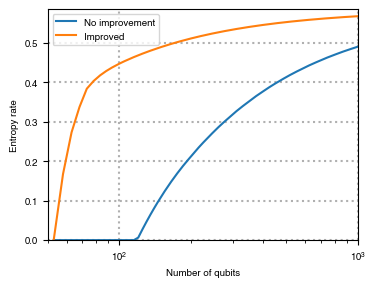

In [3]:
ns = [i for i in range(53, 101, 5)] + [i for i in range(100, 1005, 5)]
T = 1
delta = 0.585

poor_entropy = entropy(ns, delta, T, improve=False)
improved_entropy = entropy(ns, delta, T, improve=True)

plt.figure(figsize=(4,3))
plt.plot(ns, poor_entropy, '-', label='No improvement')
plt.plot(ns, improved_entropy, '-', label='Improved')
plt.grid(which='major', linestyle=':', linewidth=1.5)
plt.ylim(0, delta)
plt.xlim(50, 1000)
plt.xscale('log')
plt.ylabel('Entropy rate')
plt.xlabel('Number of qubits')
plt.legend()
# plt.savefig('Improve_entropy_vs_n_large_main.pdf')

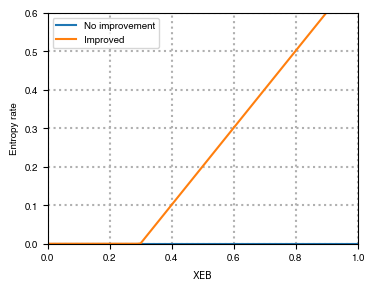

In [4]:
n = [64]
T = 1
deltas = np.arange(0, 1.01, 0.01)

poor_entropy = []
improved_entropy = []
super_improved_entropy = []
for delta in deltas:
    poor_entropy.append(entropy(n, delta, T, improve=False))
    improved_entropy.append(entropy(n, delta, T, improve=True))
poor_entropy = np.array(poor_entropy).reshape(-1)
improved_entropy = np.array(improved_entropy).reshape(-1)

plt.figure(figsize=(4,3))
plt.plot(deltas, poor_entropy, '-', label='No improvement')
plt.plot(deltas, improved_entropy, '-', label='Improved')
plt.grid(which='major', linestyle=':', linewidth=1.5)
plt.ylim(0,0.6)
plt.xlim(0,1)
plt.ylabel('Entropy rate')
plt.xlabel(r'$\text{XEB}$')
plt.legend()
# plt.savefig('Improve_entropy_vs_delta_large_main.pdf')

# Multiround analysis (Supplement figure)

### Unility function

In [5]:
# Maximizing a function that takes integer arguments
def int_maximize(f, low, high):
    prev_high = None
    prev_low = None
    mid = (low + high) // 2
    low_val, mid_val, high_val = f(low), f(mid), f(high)
    while True:
        if low >= high - 1:
            if low_val > high_val:
                return low, low_val
            else:
                return high, high_val
        vals = [low_val, mid_val, high_val]
        max_id = np.nanargmax(vals)
        if max_id == 0 and prev_low == None:
            low = low
            high = mid
            high_val = mid_val
            mid = (low + mid) // 2
            mid_val = f(mid)
        elif max_id == 0 and prev_low != None:
            high = mid
            high_val = mid_val
            mid = low
            mid_val = low_val
            low = prev_low
            low_val = prev_low_val
        elif max_id == 2 and prev_high == None:
            low = mid
            high = high
            low_val = mid_val
            mid = (mid + high) // 2
            mid_val = f(mid)
        elif max_id == 2 and prev_high != None:
            low = mid
            low_val = mid_val
            mid = high
            mid_val = high_val
            high = prev_high
            high_val = prev_high_val
        else:
            prev_high = high
            prev_low = low
            prev_high_val = high_val
            prev_low_val = low_val
            high = (high + mid) // 2
            low = (low + mid) // 2
            high_val, low_val = f(high), f(low)

def solve_xmin(ds):
    results = []
    for d in ds:
        x = np.linspace(0, 0.1, 101)
        cdf = 1 - np.exp(-x) * (1+x)
        id = np.argmin(np.abs(cdf-d))
        results.append(x[id])
    return np.array(results)

### Truncated maximum XEB contribution, one oracle access model without $\log k$ penalty

In [6]:
def H_truncated(L, gamma, n, s, xmax, PhiC, phi_adv, varepsilon, POmega, improved_variance=True):
    delta = s - 1
    dC = 0.0001
    N = 2**n
    # used for alternative variance
    step = 0.001
    xs = np.arange(0, xmax + step, step)
    pdf = np.exp(-xs) * step # Cannot use average case test score output probability distribution since it must be optimized for infimum over all input states
    
    def f(logk):
        k = int(2**logk)
        l = k
        varepsilonpp = 4 / 2**(n/2) + sqrt(2 * (1 - np.cos(np.pi / (2 * k))**k)) + 1 * 2 / np.sqrt(l + 1) + 2 * ((k/N + l/N) * (k/N + l/N - 1/N) * N) + 2*(k+l)/(N*(1-(k+l)/N))
        dQ = N**(-1/3) + (1)**2 / N + varepsilonpp
        logdQ = -n/3 + 2 * (0 + 1) - n + log2(varepsilonpp)
        dQ = 2**logdQ
        d = max(dQ, dC)
        xmin = solve_xmin([d])
        C = 1 / n * (log2(n) + 3) + 4 * varepsilonpp * (n * log(2) + 3.5) + 1.001 * 16 * log(N)**2 / N + 0.001
        C = C * phi_adv
        def h(delta):
            return n * ((((delta + 1) * (1 - N**(-1/3)) -1 - d * xmax - xmin + exp(-(xmax - xmin))) / (1 - exp(-(xmax - xmin)) * (1 + xmax - xmin)) - PhiC) * (1 - 1 / N) - C) - 2
        varf = 1 / gamma * (h(xmax) - h(0))**2

        if improved_variance:
            # alternative variance
            pdf[0] = d
            pdf[-1] = 1 - np.sum(pdf[0 : -1])
            gs = h(xs)
            varf = 1 / gamma * np.dot(pdf, (h(xmax) - gs)**2) - (h(xmax) - np.dot(pdf, gs))**2

        V = sqrt(varf + 2) + n + 1
        w = 2 * n + h(xmax) - h(0)
        a = 1 + np.sqrt(2*np.log2(2 / (varepsilon**2 * POmega**2)))/(V*np.sqrt(L*np.log(2)))
        Ka = 1 / (6 * (2-a)**3 * np.log(2)) * 2**(w*np.sqrt(2*np.log2(2 / (varepsilon**2 * POmega**2)))/(V*np.sqrt(L*np.log(2)))) * np.log(2**2 + np.exp(2))**3
        H = L * h(delta) - L * (a - 1) * log(2) * V**2 / 2 - log2(2 / varepsilon**2 / POmega**2) / (a - 1) - L * (a - 1)**2 * Ka
        return H
    k_max, H_max = int_maximize(f, 1, n // 2)
    return H_max

### One oracle access model without $\log k$ penalty, no truncation

In [7]:
def H_original(L, gamma, n, s, xmax, PhiC, phi_adv, varepsilon, POmega, improved_variance=True):
    N = 2**n
    # used for alternative variance
    step = 0.001
    xs = np.arange(0, xmax + step, step)
    pdf = np.exp(-xs) * step # Cannot use average case test score output probability distribution since it must be optimized for infimum over all input states
    pdf[-1] = 1 - np.sum(pdf[: -1])
    
    def f(logk):
        k = 2**logk
        l = k
        varepsilonpp = 4 / 2**(n/2) + sqrt(2 * (1 - np.cos(np.pi / (2 * k))**k)) + 1 * 2 / np.sqrt(l + 1) + 2 * ((k/N + l/N) * (k/N + l/N - 1/N) * N) + 2*(k+l)/(N*(1-(k+l)/N))
        def h(s):
            return phi_adv * (((s - 1 - PhiC)/phi_adv - 2 * varepsilonpp * (n * log(2) + 3.5) - 1.001 * 16 * log(N)**2 / N - 0.001) * n - np.log2(n) - 7 - 0 * np.log2(k + l))
        varf = 1 / gamma * (h(xmax) - h(0))**2

        if improved_variance:
            # alternative variance
            step = 0.001
            xs = np.arange(0, xmax + step, step)
            pdf = np.exp(-xs) * step # Cannot use average case test score output probability distribution since it must be optimized for infimum over all input states
            pdf[-1] = 1 - np.sum(pdf[: -1])
            gs = h(xs)
            varf = 1 / gamma * np.dot(pdf, (h(xmax) - gs)**2) - (h(xmax) - np.dot(pdf, gs))**2

        V = sqrt(varf + 2) + n + 1
        w = 2 * n + h(xmax) - h(0)
        a = 1 + np.sqrt(2*np.log2(2 / (varepsilon**2 * POmega**2)))/(V*np.sqrt(L*np.log(2)))
        Ka = 1 / (6 * (2-a)**3 * np.log(2)) * 2**(w*np.sqrt(2*np.log2(2 / (varepsilon**2 * POmega**2)))/(V*np.sqrt(L*np.log(2)))) * np.log(2**2 + np.exp(2))**3
        H = L * h(s) - L * (a - 1) * log(2) * V**2 / 2 - log2(2 / varepsilon**2 / POmega**2) / (a - 1) - L * (a - 1)**2 * Ka
        return H
    k_max, H_max = int_maximize(f, 1, n//2)
    return H_max

### Analysis for actual expeirmental result

In [8]:
# The truncated XEB score with offset 1
s = 0.21432 + 1
# Maximum XEB contribution truncation threshold, rescaled by 2^n
xmax = 2
# Maximum adversary quantum device fidelity
phi_adv = 0.65
# Number of qubits
n = 64
# Total number of samples
L = 23651
# Number of validation samples
L_val = 11961
# Validation probability
gamma = L_val / L
# Average time on a quantum computer
latency = 0.03
# Minimum distance of the adversary from the verifier
d_in_kms = 3000
# Time cost for validating one circuit on Aurora
t_val_one = 9.8 * 10**5 / (10624 * 6 * 2)

epsilon_2 = epsilon_ts = 10**-8
num_seeded_extraction_rounds = 10**8
epsilon_seeded = 10**-16
# Soundness security parameter
epsilon_sous = [10**-3, 10**-6]
# Adversary computational power in multiples of Aurora
As = [300, 40, 5]
for epsilon_sou in epsilon_sous:
    for A in As:
        # Adversary classical simulation fidelity
        PhiC = A * latency / t_val_one
        PhiC *= (1 - 2 * d_in_kms * 1000 / (3*10**8 * latency))
        epsilon_accept = epsilon_sou
        epsilon_smooth = (epsilon_sou - 2*epsilon_2 - 2*epsilon_ts - num_seeded_extraction_rounds * epsilon_seeded) / 6
        H = H_truncated(L, gamma, n, s, xmax, PhiC, phi_adv, epsilon_smooth, epsilon_accept, improved_variance=True)[0]
        print(f'Soundness: {epsilon_sou}, adversary: {A} times Aurora, entropy rate: {H / (L * n)}, entropy: {H}')

Soundness: 0.001, adversary: 300 times Aurora, entropy rate: -0.2465294866485877, entropy: -373162.80887844786
Soundness: 0.001, adversary: 40 times Aurora, entropy rate: 0.09170398273916751, entropy: 138809.01732889924
Soundness: 0.001, adversary: 5 times Aurora, entropy rate: 0.13723541131059602, entropy: 207728.301626042
Soundness: 1e-06, adversary: 300 times Aurora, entropy rate: -0.313056961293797, entropy: -473863.05225981394
Soundness: 1e-06, adversary: 40 times Aurora, entropy rate: 0.025176508093958234, entropy: 38108.7739475332
Soundness: 1e-06, adversary: 5 times Aurora, entropy rate: 0.07070793666538677, entropy: 107028.058244676


/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_34440/816024678.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return n * ((((delta + 1) * (1 - N**(-1/3)) -1 - d * xmax - xmin + exp(-(xmax - xmin))) / (1 - exp(-(xmax - xmin)) * (1 + xmax - xmin)) - PhiC) * (1 - 1 / N) - C) - 2
/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_34440/816024678.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V = sqrt(varf + 2) + n + 1


In [9]:
# The truncated XEB score with offset 1
s = 0.21432 + 1
# Maximum XEB contribution truncation threshold, rescaled by 2^n
xmax = 2
# Maximum adversary quantum device fidelity
phi_adv = 0.65
# Number of qubits
n = 64
# Total number of samples
L = 23651
# Number of validation samples
L_val = 11961
# Validation probability
gamma = L_val / L
# Average time on a quantum computer
latency = 0.03
# Minimum distance of the adversary from the verifier
d_in_kms = 3000
# Time cost for validating one circuit on Aurora
t_val_one = 9.8 * 10**5 / (10624 * 6 * 2)

epsilon_2 = epsilon_ts = 10**-8
num_seeded_extraction_rounds = 10**8
epsilon_seeded = 10**-16
# Soundness security parameter
epsilon_sous = [10**-3, 10**-6]
# Adversary computational power in multiples of Aurora
As = [300, 40, 5]
for epsilon_sou in epsilon_sous:
    for A in As:
        # Adversary classical simulation fidelity
        PhiC = A * latency / t_val_one
        PhiC *= (1 - 2 * d_in_kms * 1000 / (3*10**8 * latency))
        epsilon_accept = epsilon_sou
        epsilon_smooth = (epsilon_sou - 2*epsilon_2 - 2*epsilon_ts - num_seeded_extraction_rounds * epsilon_seeded) / 6
        H = H_truncated(L, gamma, n, s, xmax, PhiC, phi_adv, epsilon_smooth, epsilon_accept, improved_variance=True)[0]
        print(f'Soundness: {epsilon_sou}, adversary: {A} times Aurora, entropy rate: {H / (L * n)}, entropy: {H}')

Soundness: 0.001, adversary: 300 times Aurora, entropy rate: -0.2465294866485877, entropy: -373162.80887844786
Soundness: 0.001, adversary: 40 times Aurora, entropy rate: 0.09170398273916751, entropy: 138809.01732889924
Soundness: 0.001, adversary: 5 times Aurora, entropy rate: 0.13723541131059602, entropy: 207728.301626042
Soundness: 1e-06, adversary: 300 times Aurora, entropy rate: -0.313056961293797, entropy: -473863.05225981394
Soundness: 1e-06, adversary: 40 times Aurora, entropy rate: 0.025176508093958234, entropy: 38108.7739475332
Soundness: 1e-06, adversary: 5 times Aurora, entropy rate: 0.07070793666538677, entropy: 107028.058244676


/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_34440/816024678.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return n * ((((delta + 1) * (1 - N**(-1/3)) -1 - d * xmax - xmin + exp(-(xmax - xmin))) / (1 - exp(-(xmax - xmin)) * (1 + xmax - xmin)) - PhiC) * (1 - 1 / N) - C) - 2
/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_34440/816024678.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V = sqrt(varf + 2) + n + 1


### Hypothetical situation analysis for supplement. 4 times Aurora

In [10]:
L = 100000
n = 64
phi = 0.6
phi_adv = 0.65
d_in_kms = 0
adversary = 4 # adversary power in multiples of aurora
total_validation_time = 300000 * 3600 / 10624 # validation time in aurora seconds
latency = 0.05
varepsilon_sou = 10**-4
varepsilon_smooth = varepsilon_sou
varepsilon_accept = varepsilon_sou / 6

gammas = 1 / (2**20) * 2**np.arange(10, 20 + 1/8, 1/8)
Hs_original = []
Hs_original_improved_variance = []
Hs_truncated = []
Hs_truncated_improved_variance = []

## Simple way of determinining achievable score. Calculate the average score in the honest case.
xmax = 4 # 4 seems to be optimal
step = 0.0001
xs = np.arange(0, xmax, step)
pdf = (1 - phi + phi * xs) * np.exp(-xs) * step
xeb_mean = np.dot(xs, pdf) + (1 - pdf.sum()) * xmax
for gamma in tqdm(gammas):
    val_time_per_circuit = total_validation_time / (L * gamma)
    PhiC = adversary * latency / val_time_per_circuit
    PhiC *= (1 - 2 * d_in_kms * 1000 / (3*10**8 * latency))
    Hs_original.append(H_original(L, gamma, n, xeb_mean, xmax, PhiC, phi_adv, varepsilon_smooth, varepsilon_accept, improved_variance=False))
    Hs_original_improved_variance.append(H_original(L, gamma, n, xeb_mean, xmax, PhiC, phi_adv, varepsilon_smooth, varepsilon_accept, improved_variance=True))


## Simple way of determinining achievable score. Calculate the average score in the honest case.
xmax = 2
step = 0.0001
xs = np.arange(0, xmax, step)
pdf = (1 - phi + phi * xs) * np.exp(-xs) * step
xeb_mean = np.dot(xs, pdf) + (1 - pdf.sum()) * xmax
for gamma in tqdm(gammas):
    val_time_per_circuit = total_validation_time / (L * gamma)
    PhiC = adversary * latency / val_time_per_circuit
    PhiC *= (1 - 2 * d_in_kms * 1000 / (3*10**8 * latency))
    Hs_truncated.append(H_truncated(L, gamma, n, xeb_mean, xmax, PhiC, phi_adv, varepsilon_smooth, varepsilon_accept, improved_variance=False))
    Hs_truncated_improved_variance.append(H_truncated(L, gamma, n, xeb_mean, xmax, PhiC, phi_adv, varepsilon_smooth, varepsilon_accept, improved_variance=True))

  0%|          | 0/81 [00:00<?, ?it/s]/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_34440/816024678.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return n * ((((delta + 1) * (1 - N**(-1/3)) -1 - d * xmax - xmin + exp(-(xmax - xmin))) / (1 - exp(-(xmax - xmin)) * (1 + xmax - xmin)) - PhiC) * (1 - 1 / N) - C) - 2
/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_34440/816024678.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V = sqrt(varf + 2) + n + 1
100%|██████████| 81/81 [00:00<00:00, 429.64it/s]


### Supplementary Fig. 5a

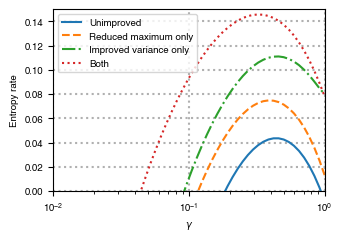

In [11]:
mm = 1/25.4  # millimeters in inches
plt.figure(figsize=(89 * mm, 60 * mm))
plt.plot(gammas, np.array(Hs_original) / (L*n), label='Unimproved')
plt.plot(gammas, np.array(Hs_truncated) / (L*n), '--', label='Reduced maximum only')
plt.plot(gammas, np.array(Hs_original_improved_variance) / (L*n), '-.', label='Improved variance only')
plt.plot(gammas, np.array(Hs_truncated_improved_variance) / (L*n), ':', label='Both')
plt.grid(which='major', linestyle=':', linewidth=1.5)
plt.plot([gamma, gamma], [0, 1], '--', linewidth=1, color='gray')
plt.xscale('log')
plt.ylim(0,0.15)
plt.xlim(10**-2, 1)
plt.xlabel(r'$\gamma$')
plt.ylabel('Entropy rate')
plt.legend()
# plt.savefig('multiround_improvement1.pdf')

### Hypothetical situation analysis for supplement. 15 times Aurora

In [12]:
L = 100000
n = 64
phi = 0.6
phi_adv = 0.65
d_in_kms = 0
adversary = 15 # adversary power in multiples of aurora
total_validation_time = 300000 * 3600 / 10624 # validation time in aurora seconds
latency = 0.05
varepsilon_sou = 10**-4
varepsilon_smooth = varepsilon_sou
varepsilon_accept = varepsilon_sou / 6

gammas = 1 / (2**20) * 2**np.arange(10, 20 + 1/8, 1/8)
Hs_original = []
Hs_original_improved_variance = []
Hs_truncated = []
Hs_truncated_improved_variance = []

## Simple way of determinining achievable score. Calculate the average score in the honest case.
xmax = 4 # 4 seems to be optimal
step = 0.0001
xs = np.arange(0, xmax, step)
pdf = (1 - phi + phi * xs) * np.exp(-xs) * step
xeb_mean = np.dot(xs, pdf) + (1 - pdf.sum()) * xmax
for gamma in tqdm(gammas):
    val_time_per_circuit = total_validation_time / (L * gamma)
    PhiC = adversary * latency / val_time_per_circuit
    PhiC *= (1 - 2 * d_in_kms * 1000 / (3*10**8 * latency))
    Hs_original.append(H_original(L, gamma, n, xeb_mean, xmax, PhiC, phi_adv, varepsilon_smooth, varepsilon_accept, improved_variance=False))
    Hs_original_improved_variance.append(H_original(L, gamma, n, xeb_mean, xmax, PhiC, phi_adv, varepsilon_smooth, varepsilon_accept, improved_variance=True))


## Simple way of determinining achievable score. Calculate the average score in the honest case.
xmax = 2
step = 0.0001
xs = np.arange(0, xmax, step)
pdf = (1 - phi + phi * xs) * np.exp(-xs) * step
xeb_mean = np.dot(xs, pdf) + (1 - pdf.sum()) * xmax
for gamma in tqdm(gammas):
    val_time_per_circuit = total_validation_time / (L * gamma)
    PhiC = adversary * latency / val_time_per_circuit
    PhiC *= (1 - 2 * d_in_kms * 1000 / (3*10**8 * latency))
    Hs_truncated.append(H_truncated(L, gamma, n, xeb_mean, xmax, PhiC, phi_adv, varepsilon_smooth, varepsilon_accept, improved_variance=False))
    Hs_truncated_improved_variance.append(H_truncated(L, gamma, n, xeb_mean, xmax, PhiC, phi_adv, varepsilon_smooth, varepsilon_accept, improved_variance=True))

  0%|          | 0/81 [00:00<?, ?it/s]/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_34440/816024678.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return n * ((((delta + 1) * (1 - N**(-1/3)) -1 - d * xmax - xmin + exp(-(xmax - xmin))) / (1 - exp(-(xmax - xmin)) * (1 + xmax - xmin)) - PhiC) * (1 - 1 / N) - C) - 2
/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_34440/816024678.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V = sqrt(varf + 2) + n + 1
100%|██████████| 81/81 [00:00<00:00, 428.63it/s]


### Supplementary Fig. 5b

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


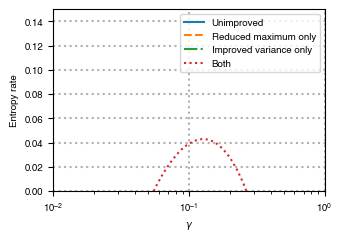

In [13]:
mm = 1/25.4  # millimeters in inches
plt.figure(figsize=(89 * mm, 60 * mm))
plt.plot(gammas, np.array(Hs_original) / (L*n), label='Unimproved')
plt.plot(gammas, np.array(Hs_truncated) / (L*n), '--', label='Reduced maximum only')
plt.plot(gammas, np.array(Hs_original_improved_variance) / (L*n), '-.', label='Improved variance only')
plt.plot(gammas, np.array(Hs_truncated_improved_variance) / (L*n), ':', label='Both')
plt.grid(which='major', linestyle=':', linewidth=1.5)
plt.plot([gamma, gamma], [0, 1], '--', linewidth=1, color='gray')
plt.xscale('log')
plt.ylim(0,0.15)
plt.xlim(10**-2, 1)
plt.xlabel(r'$\gamma$')
plt.ylabel('Entropy rate')
plt.legend()
# plt.savefig('multiround_improvement2.pdf')